THE BATTLE OF NEIGHBORHOODS
Introduction:New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , Italian, French etc.

In this project , we will list and visualize all major parts of New York City that has great French restaurants.

Data:
For this project we need the following data:

1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. French resturants in each neighborhood of new york city.
3. GeoSpace data

Questions that will be answers at the end of this project :¶
1. What are best location in New York City for French Cuisine?
2. Which areas have potential French Restaurant Market?
3. Which all areas lack French Restaurants?
4. Which is the best place to stay if you prefer French Cuisine?

Methodology:
1.We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2.We will find all venues for each neighborhood using FourSquare API.
3.We will then filter out all Indian Restuarant venues.
4.Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
5.Next we will sort the data keeping Ratings as the constraint.
6.Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [1]:
import sys
! pip install geocoder
! pip install folium
! pip install SomePackage
! pip install numpy
! pip install BeautifulSoup4
! pip install wikipedia
! pip install bs4
! pip install IPython
! pip install lxml
! pip install Nominatim
! pip install geopy

print('Packages installed.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 10.9 MB/s eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████████████

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    address ='New York,USA'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '1CVX0P22PGNHR2GYDNEIYSSE5UZHVOGVTVADWQXJ5NF5BKJ1'#
    CLIENT_SECRET = 'NU3QOJRDYYVJN0125XOZDZFQGLYVYSC5R5IEGBHXHL0SFFRO'#
    VERSION = '20180604'# 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '1CVX0P22PGNHR2GYDNEIYSSE5UZHVOGVTVADWQXJ5NF5BKJ1'#  
    CLIENT_SECRET = 'NU3QOJRDYYVJN0125XOZDZFQGLYVYSC5R5IEGBHXHL0SFFRO'#  
    VERSION = '20180604'#
    
   #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [7]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

The above result shows that there are 306 different Neighborhoods in New York.¶

Now let create a BAR PLOT to show different Neighborhoods in New York.

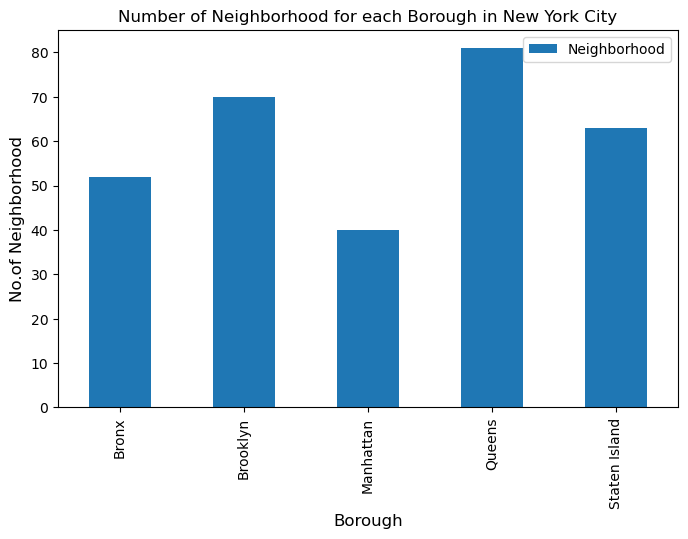

In [9]:
plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above Plot, we can see the Queens has the highest number of neighborhoods.

Next we will collect French restaurants for each Neighborhood.

In [10]:
# prepare neighborhood list that contains french restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_resturants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    for resturant_detail in french_resturants.values.tolist():
        id, name , category=resturant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name}, ignore_index=True)
        count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
( 1 / 306 ) French Resturants in Co-op City, Bronx:0
( 1 / 306 ) French Resturants in Eastchester, Bronx:0
( 1 / 306 ) French Resturants in Fieldston, Bronx:0
( 1 / 306 ) French Resturants in Riverdale, Bronx:0
( 1 / 306 ) French Resturants in Kingsbridge, Bronx:0
( 1 / 306 ) French Resturants in Marble Hill, Manhattan:0
( 1 / 306 ) French Resturants in Woodlawn, Bronx:0
( 1 / 306 ) French Resturants in Norwood, Bronx:0
( 1 / 306 ) French Resturants in Williamsbridge, Bronx:0
( 1 / 306 ) French Resturants in Baychester, Bronx:0
( 1 / 306 ) French Resturants in Pelham Parkway, Bronx:0
( 1 / 306 ) French Resturants in City Island, Bronx:1
( 2 / 306 ) French Resturants in Bedford Park, Bronx:0
( 2 / 306 ) French Resturants in University Heights, Bronx:0
( 2 / 306 ) French Resturants in Morris Heights, Bronx:0
( 2 / 306 ) French Resturants in Fordham, Bronx:0
( 2 / 306 ) French Resturants in East Tremont, Bronx:0
( 2 / 306 ) French Restur

Now that we have got all the French resturants in new york city , we will analyze it.

In [11]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock


In [12]:
french_rest_ny.shape

(88, 4)

From the above result, we see that there are 84 French Resturants across New York City.


Now let create a BAR PLOT to show Number of French Resturants for each Borough in New York City.

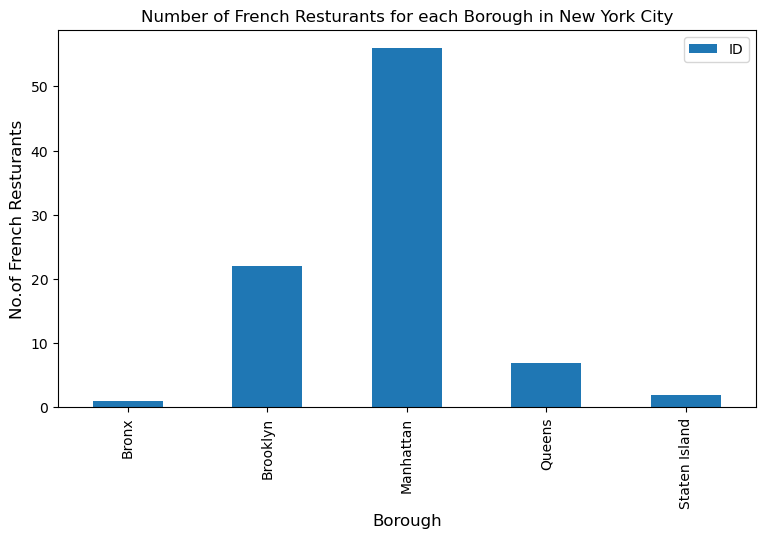

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=12)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the Plot, we can see that MANHATTHAN has highest number of French resturants.

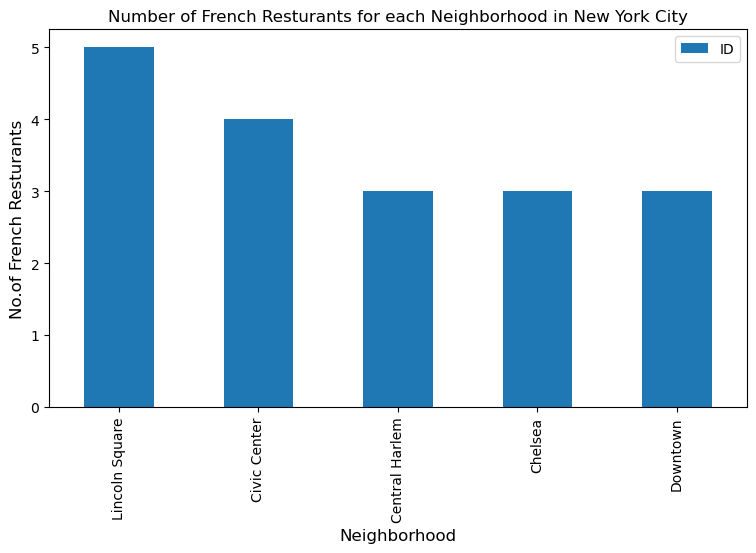

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 12)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=12)
#giving a bar plot
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
french_rest_ny[french_rest_ny['Neighborhood']=='Lincoln Square']

,Borough,Neighborhood,ID,Name
34,Manhattan,Lincoln Square,414ccc00f964a520d21c1fe3,Cafe Luxembourg
35,Manhattan,Lincoln Square,478cd1f3f964a520444d1fe3,Bar Boulud
36,Manhattan,Lincoln Square,3fd66200f964a520bee91ee3,Jean-Georges
37,Manhattan,Lincoln Square,49e7897ff964a520b6641fe3,Nougatine at Jean Georges
38,Manhattan,Lincoln Square,41f19780f964a520101f1fe3,Per Se


We can see that, Lincoln Square in Manhattan has the highest number of French Resturants with a total count of 5.¶

Now we will get the ranking of each resturant for further analysis.

In [16]:
# prepare neighborhood list that contains french resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains french resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(french_rest_ny),')','processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     12     7.5     7
( 1 / 88 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bf358689fca56002c251a87  Citroën     25     8.4     3
( 2 / 88 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    224     9.1    60
( 3 / 88 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    161     7.8    73
( 4 / 88 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    141     8.8    56
( 5 / 88 ) processed
                         ID       Name  Likes  Rating  Tips
0  55e47d26498e44d12c7c004e  Le Garage     99     8.3    25
( 6 / 88 ) processed
                         ID       Name  Likes  Rating  Tips
0  50b99e4ae4b0c22ba9633dfd  Mominette    342     8.2    81
( 7 / 88 ) processed
         

In [17]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,25,8.4,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,224,9.1,60
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,161,7.8,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,141,8.8,56


In [18]:
french_rest_stats_ny.shape

(88, 7)

In [19]:
french_rest_ny.shape

(88, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [20]:
french_rest_stats_ny.to_csv('french_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [21]:
french_rest_stats_ny_csv=pd.read_csv('french_rest_stats_ny.csv')

In [22]:
french_rest_stats_ny_csv.shape

(88, 7)

In [23]:
french_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,25,8.4,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,224,9.1,60
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,161,7.8,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,141,8.8,56


In [24]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       88 non-null     object 
 1   Neighborhood  88 non-null     object 
 2   ID            88 non-null     object 
 3   Name          88 non-null     object 
 4   Likes         88 non-null     object 
 5   Rating        88 non-null     float64
 6   Tips          88 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.9+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [25]:
french_rest_stats_ny['Likes']=french_rest_stats_ny['Likes'].astype('float64')
french_rest_stats_ny['Tips']=french_rest_stats_ny['Tips'].astype('float64')

In [26]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       88 non-null     object 
 1   Neighborhood  88 non-null     object 
 2   ID            88 non-null     object 
 3   Name          88 non-null     object 
 4   Likes         88 non-null     float64
 5   Rating        88 non-null     float64
 6   Tips          88 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.9+ KB


Now we will find the French restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [27]:
# Resturant with maximum Likes
french_rest_stats_ny.iloc[french_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              3fd66200f964a52070e91ee3
Name                           Balthazar
Likes                               3042
Rating                               8.9
Tips                                1049
Name: 47, dtype: object

In [28]:
# Resturant with maximum Rating
french_rest_stats_ny.iloc[french_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              58fd34584382ab70ad90083e
Name                       Chez Ma Tante
Likes                                224
Rating                               9.1
Tips                                  60
Name: 2, dtype: object

In [29]:
# Resturant with maximum Tips
french_rest_stats_ny.iloc[french_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              3fd66200f964a52070e91ee3
Name                           Balthazar
Likes                               3042
Rating                               8.9
Tips                                1049
Name: 47, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [30]:
ny_neighborhood_stats=french_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
24,Greenwich Village,9.000000
18,East Harlem,8.900000
34,Midtown,8.900000
31,Lower East Side,8.850000
52,Yorkville,8.800000
51,Windsor Terrace,8.800000
9,Chelsea,8.800000
27,Lenox Hill,8.633333
28,Lincoln Square,8.620000
33,Manhattanville,8.600000


Above are the top neighborhoods with top average rating of French restaurants 

Similarly we will find the average rating of French restaurants for each Borough.

In [32]:
ny_borough_stats=french_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [33]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,8.063636
0,Bronx,7.500000
2,Manhattan,4.316071
3,Queens,0.000000
4,Staten Island,0.000000


Let's Visualize it.

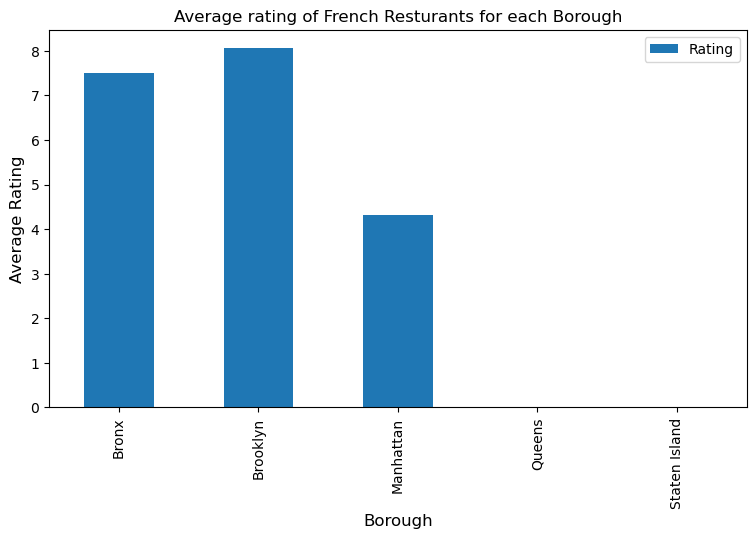

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of French Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('Average Rating', fontsize=12)
#giving a bar plot
french_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map.

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0] 

In [36]:
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bedford Stuyvesant,8.450000
3,Boerum Hill,8.550000
4,Brooklyn Heights,8.500000
5,Bushwick,8.250000
7,Carroll Gardens,8.450000
8,Central Harlem,8.400000
9,Chelsea,8.800000
10,Chinatown,8.600000
13,Clinton,8.150000
14,Clinton Hill,8.600000


We will join this dataset to original new york data to get lonitude and latitude.

In [37]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [39]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
16,Manhattan,Greenwich Village,40.726933,-73.999914,9.000000
13,Manhattan,East Harlem,40.792249,-73.944182,8.900000
21,Manhattan,Midtown,40.754691,-73.981669,8.900000
19,Manhattan,Lower East Side,40.717807,-73.980890,8.850000
28,Manhattan,Yorkville,40.775930,-73.947118,8.800000
27,Brooklyn,Windsor Terrace,40.656946,-73.980073,8.800000
6,Manhattan,Chelsea,40.744035,-74.003116,8.800000
7,Staten Island,Chelsea,40.594726,-74.189560,8.800000
17,Manhattan,Lenox Hill,40.768113,-73.958860,8.633333
18,Manhattan,Lincoln Square,40.773529,-73.985338,8.620000


Finally, Let's show this data on a map.

In [40]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [41]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Best neighbourhoods in New York that has highest average rating for French Restaurants.

In [43]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Conclusion: